## PCA in Python

[link](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html)

The main purposes of a principal component analysis are the analysis of data to identify patterns and finding patterns to reduce the dimensions of the dataset with minimal loss of information.

Here, our desired outcome of the principal component analysis is to project a feature space (our dataset consisting of n d-dimensional samples) onto a smaller subspace that represents our data “well”. A possible application would be a pattern classification task, where we want to reduce the computational costs and the error of parameter estimation by reducing the number of dimensions of our feature space by extracting a subspace that describes our data “best”.

**In PCA, we are interested to find the directions (components) that maximize the variance in our dataset**

### PCA vs MDA

Both Multiple Discriminant Analysis (MDA) and Principal Component Analysis (PCA) are linear transformation methods and closely related to each other. In PCA, we are interested to find the directions (components) that maximize the variance in our dataset, where in MDA, we are additionally interested to find the directions that maximize the separation (or discrimination) between different classes (for example, in pattern classification problems where our dataset consists of multiple classes. In contrast two PCA, which ignores the class labels).

**In other words, via PCA, we are projecting the entire set of data (without class labels) onto a different subspace, and in MDA, we are trying to determine a suitable subspace to distinguish between patterns that belong to different classes. Or, roughly speaking in PCA we are trying to find the axes with maximum variances where the data is most spread (within a class, since PCA treats the whole data set as one class), and in MDA we are additionally maximizing the spread between classes.**


### What is a good subspace?

Let’s assume that our goal is to reduce the dimensions of a d-dimensional dataset by projecting it onto a (k)-dimensional subspace (where k<d). So, how do we know what size we should choose for k, and how do we know if we have a feature space that represents our data “well”?
Later, we will compute eigenvectors (the components) from our data set and collect them in a so-called scatter-matrix (or alternatively calculate them from the covariance matrix). Each of those eigenvectors is associated with an eigenvalue, which tell us about the “length” or “magnitude” of the eigenvectors. If we observe that all the eigenvalues are of very similar magnitude, this is a good indicator that our data is already in a “good” subspace. Or if some of the eigenvalues are much much higher than others, we might be interested in keeping only those eigenvectors with the much larger eigenvalues, since they contain more information about our data distribution. Vice versa, eigenvalues that are close to 0 are less informative and we might consider in dropping those when we construct the new feature subspace.



For the following example, we will generate 40 3-dimensional samples randomly drawn from a multivariate Gaussian distribution. 
Here, we will assume that the samples stem from two different classes, where one half (i.e., 20) samples of our data set are labeled ω1 (class 1) and the other half ω2 (class 2).

In [8]:
import numpy as np

np.random.seed(42) # random seed for consistency

# A reader pointed out that Python 2.7 would raise a
# "ValueError: object of too small depth for desired array".
# This can be avoided by choosing a smaller random seed, e.g. 1
# or by completely omitting this line, since I just used the random seed for
# consistency.

mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])

# Draw random samples from a multivariate normal distribution 



class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T


print(len(class1_sample), len(class1_sample[1]))

mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T



3 20


Just to get a rough idea how the samples of our two classes ω1 and ω2 are distributed, let us plot them in a 3D scatter plot.

In [15]:
class1_sample[0:3, :]

array([[ 0.49671415,  1.52302986,  1.57921282,  0.54256004,  0.24196227,
        -0.56228753, -0.90802408, -0.2257763 , -0.54438272,  0.37569802,
        -0.60170661, -1.05771093,  0.2088636 ,  0.19686124, -0.11564828,
        -0.71984421,  0.34361829, -0.38508228,  1.03099952, -0.30921238],
       [-0.1382643 , -0.23415337,  0.76743473, -0.46341769, -1.91328024,
        -1.01283112, -1.4123037 ,  0.0675282 ,  0.11092259, -0.60063869,
         1.85227818,  0.82254491, -1.95967012,  0.73846658, -0.3011037 ,
        -0.46063877, -1.76304016, -0.676922  ,  0.93128012,  0.33126343],
       [ 0.64768854, -0.23413696, -0.46947439, -0.46572975, -1.72491783,
         0.31424733,  1.46564877, -1.42474819, -1.15099358, -0.29169375,
        -0.01349722, -1.22084365, -1.32818605,  0.17136828, -1.47852199,
         1.05712223,  0.32408397,  0.61167629, -0.83921752,  0.97554513]])

Populating the interactive namespace from numpy and matplotlib


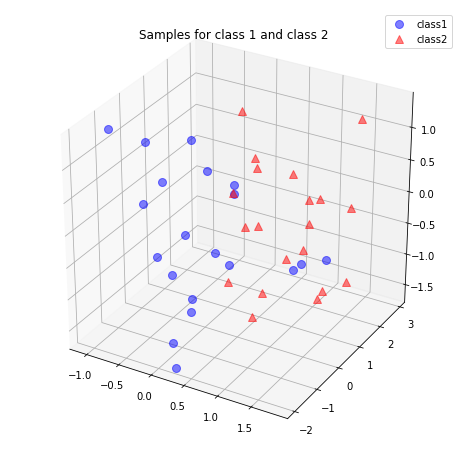

In [19]:
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection = '3d')
plt.rcParams['legend.fontsize'] = 10   

ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:],
        'o', markersize=8, color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[0,:], class2_sample[1,:],class1_sample[2,:],
        '^', markersize=8, alpha=0.5, color='red', label='class2')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()


Because we don’t need class labels for the PCA analysis, let us merge the samples for our 2 classes into one 3×40-dimensional array.

In [22]:
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)
print(len(all_samples), len(all_samples[0]))

3 40


Computing the d-dimensional mean vector

In [26]:
mean_x = np.mean(all_samples[0, :])
mean_y = np.mean(all_samples[1, :])
mean_z= np.mean(all_samples[2, :])

mean_vector = np.array([[mean_x],[mean_y],[mean_z]])

print (mean_vector)

[[ 0.45587059]
 [ 0.46810083]
 [ 0.33852142]]


Computing the Scatter Matrix

In [35]:
# 40th col

all_samples[:,39]

array([-0.16867804,  2.14282281,  1.75193303])

In [52]:
scatter_matrix = np.zeros((3,3))


for col_index in range(all_samples.shape[1]):
    scatter_matrix += ((all_samples[:, col_index].reshape(3,1) - mean_vector).dot((all_samples[:, col_index].reshape(3,1) - mean_vector).T))
    
print (scatter_matrix)


[[ 22.16567148  12.53976465   2.79387084]
 [ 12.53976465  60.31432017  16.34412085]
 [  2.79387084  16.34412085  58.05790884]]


## Calculating Cov matrix for the set of observations

Alternatively, instead of calculating the scatter matrix, we could also calculate the covariance matrix using the in-built numpy.cov() function. The equations for the covariance matrix and scatter matrix are very similar, the only difference is, that we use the scaling factor 1N−1 (here: 140−1=139) for the covariance matrix. Thus, their eigenspaces will be identical (identical eigenvectors, only the eigenvalues are scaled differently by a constant factor).

% <![CDATA[
\Sigma_i = \Bigg[
\begin{array}{cc}
\sigma_{11}^2 & \sigma_{12}^2 & \sigma_{13}^2\\
\sigma_{21}^2 & \sigma_{22}^2 & \sigma_{23}^2\\
\sigma_{31}^2 & \sigma_{32}^2 & \sigma_{33}^2\\
\end{array} \Bigg] %]]>

In [56]:
cov_mat = np.cov([all_samples[0,:],all_samples[1,:],all_samples[2,:]])

print (cov_mat)

[[ 0.56835055  0.32153243  0.07163771]
 [ 0.32153243  1.54652103  0.41908002]
 [ 0.07163771  0.41908002  1.48866433]]


## Computing eigenvectors and corresponding eigenvalues from Scatter matrix and COv matrix

To show that the eigenvectors are indeed identical whether we derived them from the scatter or the covariance matrix, let us put an assert statement into the code. Also, we will see that the eigenvalues were indeed scaled by the factor 39 when we derived it from the scatter matrix.


In [58]:
# eigenvectors and eigenvalues for the from the scatter matrix

# Returns two objects, a 1-D array containing the eigenvalues of a, 
# and a 2-D square array or matrix (depending on the input type) of the corresponding eigenvectors (in columns).



eig_val_sc, eig_vec_sc = np.linalg.eig(scatter_matrix)

# eigenvectors and eigenvalues for the from the covariance matrix

eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)

# NOTE: eigenvalues are in COLUMNS

[ 77.82139338  18.29362604  44.42288106]
[[-0.19917457 -0.95000993 -0.2404384 ]
 [-0.74116832  0.30654625 -0.59724276]
 [-0.64109204 -0.05924975  0.76517348]]


## Check for:  A.v = lambda*v

In [99]:
first_eigen_vec = eig_vec_sc[:, 0]

print (first_eigen_vec)

# A.v = lambda*v

first_eigen_val = float(eig_val_sc[0])

lhs = scatter_matrix.dot(first_eigen_vec.reshape(3,1))
print (lhs)

rhs = first_eigen_val * first_eigen_vec

print (rhs)

[-0.19917457 -0.74116832 -0.64109204]
[[-15.50004287]
 [-57.6787516 ]
 [-49.89067601]]
[-15.50004287 -57.6787516  -49.89067601]


In [101]:
# Make a list of (eigenvalue, eigenvector) tuples

eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]


# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print (eig_pairs)

[(77.821393384264596, array([-0.19917457, -0.74116832, -0.64109204])), (44.422881062246489, array([-0.2404384 , -0.59724276,  0.76517348])), (18.293626039055113, array([-0.95000993,  0.30654625, -0.05924975]))]


For our simple example, where we are reducing a 3-dimensional feature space to a 2-dimensional feature subspace, we are combining the two eigenvectors with the highest eigenvalues to construct our d×k-dimensional eigenvector matrix W.

In [133]:
matrix_w = np.matrix([eig_pairs[0][1], eig_pairs[1][1]])

matrix_w = matrix_w.T

print (matrix_w)

print (matrix_w.shape)

[[-0.19917457 -0.2404384 ]
 [-0.74116832 -0.59724276]
 [-0.64109204  0.76517348]]
(3, 2)


In the last step, we use the 2×3-dimensional matrix WW that we just computed to transform our samples onto the new subspace via the equation y=W^T × x.

In [117]:
all_samples.shape

(3, 40)

In [119]:
transformed = matrix_w.T.dot(all_samples)

print (transformed.shape)

transformed

(2, 40)


matrix([[-0.41168368,  0.02030158, -0.58236106,  0.53398199,  2.47570107,
          0.66121026,  0.28799431,  0.90831386,  0.76410771,  0.55734742,
         -1.24435229,  0.38369804,  2.26233461, -0.69640063,  1.1940714 ,
         -0.19292712,  1.03050183,  0.18627094, -0.35756854, -0.80934894,
         -0.63912851, -2.81487408, -2.54272113, -2.70682146, -1.05446588,
         -1.61796232,  0.01424167, -2.41567202, -1.63537416, -1.58332399,
         -1.86861865, -0.28730704, -1.83717866, -0.21601082, -0.81515344,
         -3.17181328, -0.34744652, -3.19995969, -1.74436542, -2.67774634],
        [ 0.45874229, -0.40550384, -1.19727759, -0.21004346, -0.23534563,
          0.98055529,  2.18328759, -1.07622497, -0.81606697,  0.04519856,
         -0.97191408, -1.17110186,  0.10388722, -0.35725036, -0.92368753,
          1.25707326,  1.2183244 ,  0.96491381, -1.44623918,  0.6229631 ,
         -0.6929505 ,  0.76759007, -0.37783214,  1.04362777, -3.00292531,
         -0.55090532,  0.92440356, -1

In [132]:
print (transformed[0][0])

[[-0.41168368  0.02030158 -0.58236106  0.53398199  2.47570107  0.66121026
   0.28799431  0.90831386  0.76410771  0.55734742 -1.24435229  0.38369804
   2.26233461 -0.69640063  1.1940714  -0.19292712  1.03050183  0.18627094
  -0.35756854 -0.80934894 -0.63912851 -2.81487408 -2.54272113 -2.70682146
  -1.05446588 -1.61796232  0.01424167 -2.41567202 -1.63537416 -1.58332399
  -1.86861865 -0.28730704 -1.83717866 -0.21601082 -0.81515344 -3.17181328
  -0.34744652 -3.19995969 -1.74436542 -2.67774634]]
